**0.Libraries**

In [2]:
!pip install  git+https://github.com/scikit-multiflow/scikit-multiflow

  Cloning https://github.com/scikit-multiflow/scikit-multiflow to /tmp/pip-req-build-uilghazi
  Running command git clone -q https://github.com/scikit-multiflow/scikit-multiflow /tmp/pip-req-build-uilghazi
  Created wheel for scikit-multiflow: filename=scikit_multiflow-0.5.dev0-cp36-cp36m-linux_x86_64.whl size=930995 sha256=4ede15cd5bbf7f25e486156e6d65d5483fc1993d0e0f88c54d63363d29db474e
  Stored in directory: /tmp/pip-ephem-wheel-cache-bu1fckvv/wheels/45/77/32/db97a8965573a1da8d6eb430c3ac6ebca714e7ab156c15912a
Successfully built scikit-multiflow


In [3]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.externals import joblib #to load and store the model
from sklearn.model_selection import train_test_split
from skmultiflow.trees import HoeffdingTree #Decision Tree with incremental learning

import time
from threading import Event,Thread


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Connecting google drive to import data

In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**1.Data Preprocessing**

In [0]:
dataFile = open('/content/drive/My Drive/Colab Notebooks/OS/Bhargav_&_Jeet_OS_Project/Code and Data/OS_Data.csv', 'r')
data = pd.read_csv(dataFile) #load data from csv file

data[['Internet', 'Location', 'Audiocable']] = (data[['Internet', 'Location', 'Audiocable']]).astype(int) #datatype coversion from boolean to binary integer

#seperate features and labels
x = data[['Internet', 'Minute', 'Hour', 'Weekday', 'Location', 'Audiocable']]  
y = data['LABEL']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.5) #splitting for training and testing

**2.Simulations with two threads**

Functions for threading

In [0]:
#
def learn(x_train,y_train,event,event2):
    length = int(len(x_train.index)/5)
    classifier=HoeffdingTree()
    cnt=0

    
    for i in range(len(x_train.index)):
        x=np.expand_dims(x_train.iloc[i],axis=0)
        y=np.expand_dims(y_train.iloc[i],axis=0)
        classifier.partial_fit(x,y,range(32))

        if cnt == length-1:      #periodic dump

            cnt = 0
            event2.wait()
            event.clear()
            #print("\n***********************************************************Saving Model")
            joblib.dump(classifier, "model.pkl")
            event.set()
    
        cnt += 1
    
#
def predict(x_test,y_test,event,event2):

    length = int(len(x_test.index)/5)
    response = [1.8, 8.5, 1.9, 11.2, 1.3]

    number_of_app = 5
    cnt = 0

    ff_tot = np.zeros(number_of_app,dtype=float)
    avg = np.zeros(number_of_app,dtype=float)
    num = np.zeros(number_of_app,dtype=int)

    event.wait()
    event.clear()
    classifier=joblib.load("model.pkl")
    event.set()

    for i in range(len(x_test.index)):

        x=np.expand_dims(x_test.iloc[i],axis=0)
        y_pred=classifier.predict(x)


        ybin_a = bin(y_test.iloc[i])[2:].zfill(number_of_app)#fixed length binary form conversion with removal of 0b from the start
        ybin_p = bin(y_pred[0])[2:].zfill(number_of_app)


        for j in range(number_of_app):
            if ybin_a[j] == '1':
                num[j] += 1
                if ybin_p[j] == '0':
                    ff_tot[j] += response[j]

            avg[j] = ff_tot[j]/num[j]
            
        if cnt == length:       #periodic update and plot
            cnt = 0
            
            fig, ax = plt.subplots(figsize=(number_of_app*3,8))
            index = np.arange(number_of_app)
            bar_width = 0.25
            opacity = 0.8
            bar_chart_no_ml = plt.bar(index+bar_width, response, 
                            bar_width, 
                            alpha = opacity, 
                            color = 'g', 
                            label = "Application response time without ML")
            print(avg)
            bar_chart_ml = plt.bar(index, avg, 
                            bar_width, 
                            alpha = opacity, 
                            color = 'b', 
                            label = "Application response time with ML")

            plt.xlabel('Applications')
            plt.ylabel('Average Response Time(seconds)')
            plt.title('Average Response Time Comparison over 500 application startups')
            plt.xticks(index+bar_width/2, ('Fire Fox', 'Matlab', 'PDF Viewer', 'PUBG', 'VLC'))
            plt.yticks(np.arange(1, 13, 1))
            plt.legend()
            plt.ylim((0, 12))
            plt.tight_layout()
            plt.savefig('HT_compare'+str(i)+'.png')
            plt.grid()
            plt.show()
            

            event.wait()
            event2.clear()
            #print("\n****************************************************************Loading Model")
            classifier=joblib.load("model.pkl")
            event2.set()
            
        cnt += 1


Thread initialization

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


[0.4754717  0.         0.66086957 2.03636364 0.156     ]


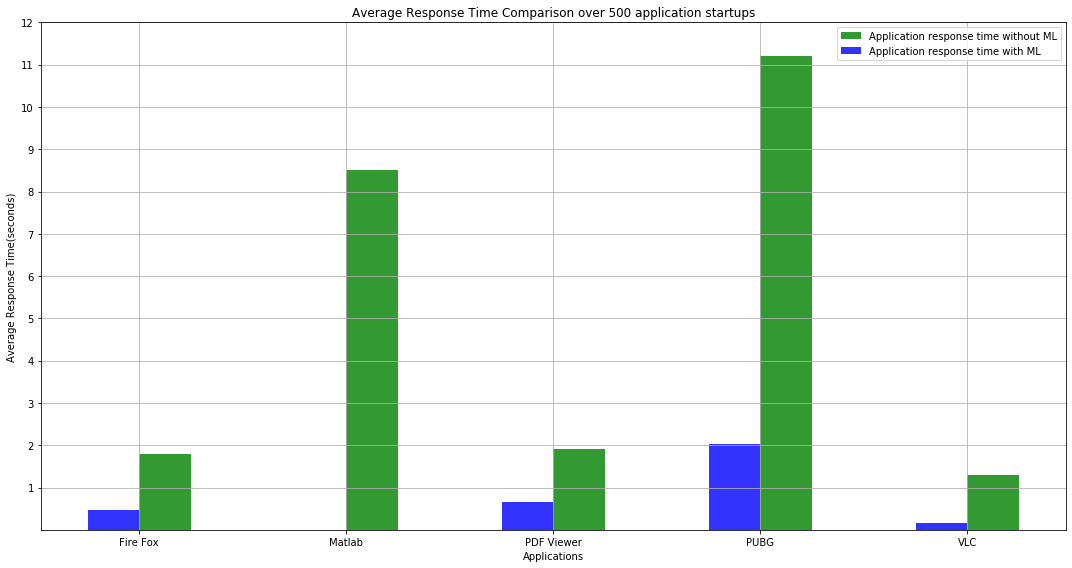

[0.45       0.         0.67555556 2.08627451 0.11037736]


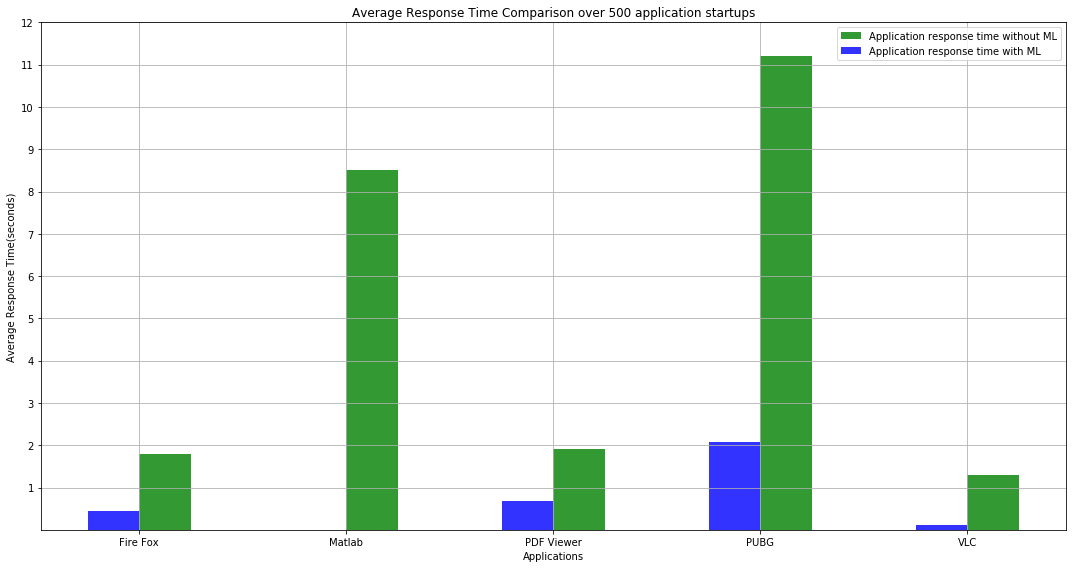

[0.45931034 0.         0.66433566 2.17986577 0.10903226]


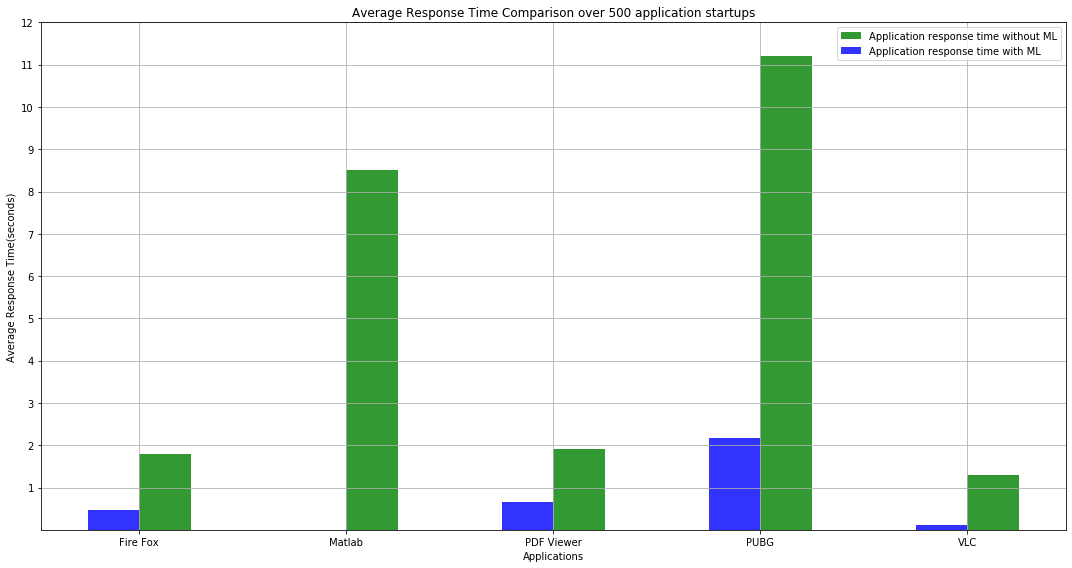

[0.49591837 0.         0.7125     2.352      0.13448276]


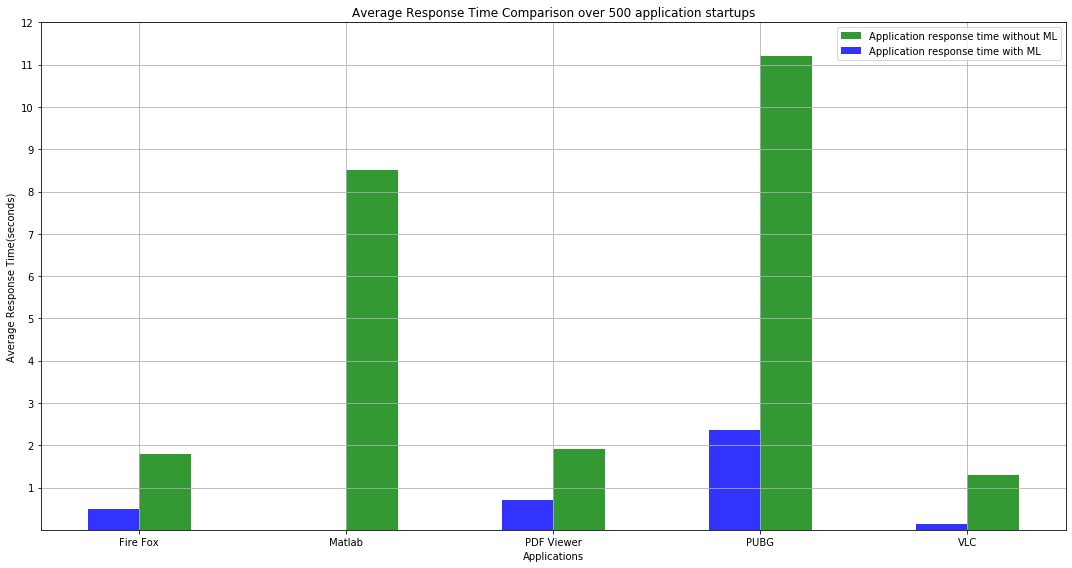

[0.4896     0.         0.70571429 2.70967742 0.14960317]


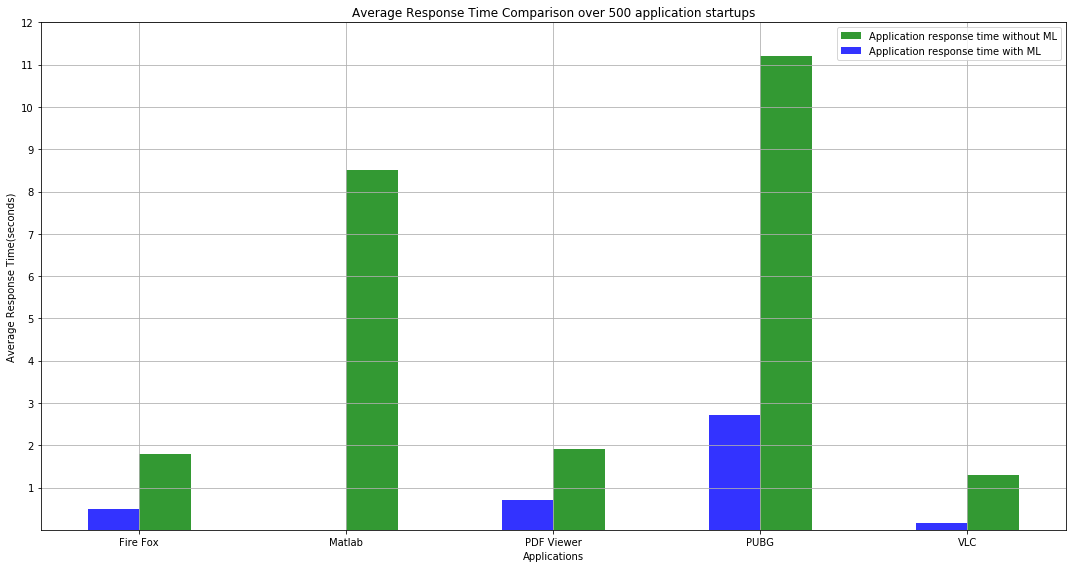

In [8]:
#event for communication between processes to share model.pkl
event = Event() #for learner to signal to predictor
event2 = Event()  #for predictor to signal to learner

#define threads
learner = Thread(target=learn, args=(x_train,y_train,event,event2)) 
predictor = Thread(target=predict, args=(x_test,y_test,event,event2)) 

# start threads
event2.set() 
learner.start()
predictor.start()

#join so cell waits for both threads to end
learner.join()
predictor.join()